## Facial Emotion Expression Recognization using CNN Sequential Model

Done By

Venkata Sai Anirudh Vinjamuri - 032170981

Vyshnavi Mandadi - 032161660

Import the dataset from the /kaggle/input

In [57]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'haar-cascades-for-face-detection:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F452468%2F854304%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240515%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240515T165747Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D88ec33b29972c4640bf42126c64c8c975c294553ab7293dc913187e89c0a1da6fdd100582e4af98b36becf61b062e3673771cde75f4261d0e5ca22a06e5e13d1691748c397563f019104853bbe8b24a14e68fd459f397f54f512983b4f5ffd1b662c8c250e359eedf1995b0f79502d8e7b4afcded22e5393904470b50c8728f61d31a4cda31b07dd80779a22394e79801532ab10b55d8a5e9ed5543dc1cd0a2bf1c90ddacee9791adef078918d058f1f5ef102119a681fe30c0c850adcb2a868226ebb29cf8361007bfa729ac3b611d393aec2cb5e47449aa371d7499d4df8512203e9fa9d1d7f1f3ce31f1b7fb31dd9cc4a287fc7c8e9f1e2ac9820ba8d2ce2,fer2013:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F786787%2F1351797%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240515%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240515T165747Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D1ad30ef0109de6a9cf1f9c64f54ec1028b76e3922affb450685253cf9f318474906d0809b85d6b2ffeec5e85e14d5d9390deb741662ba6d31da66f171a317ed5b892e8a0aec493da7818f69c76f94f137fc2898e6599c08e05ddce4305ec111f9af45059b70862f78351a48a4fb8c1984879e58fa0aeef37bf6500c8c72deb24e08088736538ceedf4a3afc44de5b5a1ab783a98e955fe20b2c5e769b0285e0a7a9836dfcc825208ced55b5c264aab49ad59f050b5711cc11458654c63767e624fe46fdd4f42f3c81c9c470b21903ec20263faaf9dfc1a7ec3d984c4edf1f6b5232b63d980e0a300dc2d60a2da24ab7be5135b5f67b927dc954c3be6e6c9e17d'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 1250608 bytes downloaded
Downloaded and uncompressed: haar-cascades-for-face-detection
[==================================================] 63252113 bytes downloaded
Downloaded and uncompressed: fer2013
Data source import complete.


In [58]:
import os
import random
import shutil

In [59]:
import numpy as np
import cv2 as cv
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras as kr

In [60]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Dropout,BatchNormalization,Flatten,AveragePooling2D
from tensorflow.keras.optimizers import Adam,RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

In [61]:
from IPython.display import HTML
import matplotlib.animation as animation

# Data Path Process

In [62]:
train_path = "/kaggle/input/fer2013/train"
test_path = "/kaggle/input/fer2013/test"

In [63]:
name_list = ["ANGRY","DISGUST","FEAR","HAPPY","NEUTRAL","SAD","SURPRISE"]

In [64]:
angry = []
disgust = []
fear = []
happy = []
neutral = []
sad = []
surprise = []

In [65]:
data_list = []

In [66]:
for r,d,f in os.walk(train_path,topdown=False):
    if "angry" in r:
        for x_name in f:
            angry.append(os.path.join(r,x_name))
            data_list.append((os.path.join(r,x_name),0))
    elif "disgust" in r:
        for x_name in f:
            disgust.append(os.path.join(r,x_name))
            data_list.append((os.path.join(r,x_name),1))
    elif "fear" in r:
        for x_name in f:
            fear.append(os.path.join(r,x_name))
            data_list.append((os.path.join(r,x_name),2))
    elif "happy" in r:
        for x_name in f:
            happy.append(os.path.join(r,x_name))
            data_list.append((os.path.join(r,x_name),3))
    elif "neutral" in r:
        for x_name in f:
            neutral.append(os.path.join(r,x_name))
            data_list.append((os.path.join(r,x_name),4))
    elif "sad" in r:
        for x_name in f:
            sad.append(os.path.join(r,x_name))
            data_list.append((os.path.join(r,x_name),5))
    elif "surprise" in r:
        for x_name in f:
            surprise.append(os.path.join(r,x_name))
            data_list.append((os.path.join(r,x_name),6))
    else:
        pass

print("[+] DONE - SUCCESS")

[+] DONE - SUCCESS


In [67]:
full_list = [angry,disgust,fear,happy,neutral,sad,surprise]

In [68]:
for x_n,x_l in zip(name_list,full_list):
    print(f"LEN OF {x_n} FILE: {len(x_l)}")

LEN OF ANGRY FILE: 3995
LEN OF DISGUST FILE: 436
LEN OF FEAR FILE: 4097
LEN OF HAPPY FILE: 7215
LEN OF NEUTRAL FILE: 4965
LEN OF SAD FILE: 4830
LEN OF SURPRISE FILE: 3171


In [69]:
print(f"TOTAL DATA LEN: {len(data_list)}")

TOTAL DATA LEN: 28709


In [70]:
random.shuffle(data_list)

In [71]:
path_all = []
class_all = []
for x_cnt in range(len(data_list)):
    path_all.append(data_list[x_cnt][0])
    class_all.append(data_list[x_cnt][1])

In [72]:
pt_series = pd.Series(path_all,name="PATH")
cl_series = pd.Series(class_all,name="CLASS")

In [73]:
dataframe = pd.concat([pt_series,cl_series],axis=1)

In [74]:
print(f"UNIQUE TARGETS: {np.unique(dataframe.CLASS.values)}")

UNIQUE TARGETS: [0 1 2 3 4 5 6]


# Image and Parameter Control

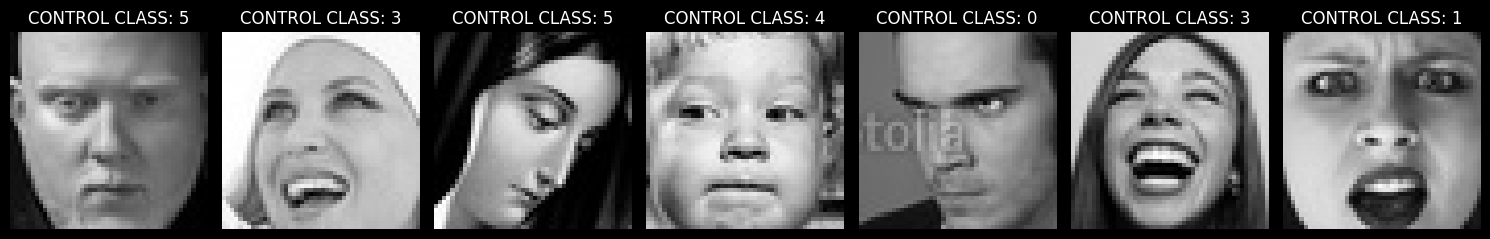

In [78]:
plt.figure(figsize=(15,25))
i_c = 1
for x_path in range(len(dataframe.PATH.values)):
    plt.subplot(1,7,i_c)
    img = cv.cvtColor(cv.imread(dataframe.PATH[x_path*50]),cv.COLOR_BGR2RGB)
    plt.axis("off")
    plt.title(f"CONTROL CLASS: {dataframe.CLASS[x_path*50]}")
    plt.imshow(img)
    if i_c == 7:
        break
    i_c += 1
plt.tight_layout()
plt.show()

# Before Training

In [79]:
def convert_process(lm:list,ls:list,dt:classmethod,pr:str,tr:str)->RESULTS:
    for x_path in range(len(dt[pr].values)):
        img = cv.cvtColor(cv.imread(dt[pr][x_path]),cv.COLOR_BGR2GRAY)
        trg = dt[tr][x_path]
        img = img.reshape(img.shape[0],img.shape[1])
        img = img / 255.
        lm.append(img)
        ls.append(trg)

In [80]:
data_image = []
target_image = []
convert_process(data_image,target_image,dataframe,"PATH","CLASS")

In [81]:
print(f"TOTAL LEN OF DATA: {len(data_image)}")
print(f"TOTAL LEN OF TARGET CLASS: {len(target_image)}")

TOTAL LEN OF DATA: 28709
TOTAL LEN OF TARGET CLASS: 28709


In [82]:
data_array = np.array(data_image)
target_array = np.array(target_image)

In [83]:
print(f"DATA SHAPE: {data_array.shape}")
print(f"TARGET SHAPE: {target_array.shape}")

DATA SHAPE: (28709, 48, 48)
TARGET SHAPE: (28709,)


In [84]:
val_data = data_array[data_array.shape[0]-2000:,:,:]
val_target = target_array[target_array.shape[0]-2000:]

In [85]:
data_array = data_array[0:data_array.shape[0]-2000,:,:]
target_array = target_array[0:target_array.shape[0]-2000]

In [86]:
print(f"VALIDATE DATA SHAPE: {val_data.shape}")
print(f"VALIDATE TARGET SHAPE: {val_target.shape}")

VALIDATE DATA SHAPE: (2000, 48, 48)
VALIDATE TARGET SHAPE: (2000,)


In [87]:
print(f"LAST DATA SHAPE: {data_array.shape}")
print(f"LAST TARGET SHAPE: {target_array.shape}")

LAST DATA SHAPE: (26709, 48, 48)
LAST TARGET SHAPE: (26709,)


In [90]:
mpath = "modelcheckpoint"
if os.path.exists(mpath):
    pass
else:
    os.mkdir(mpath)

In [91]:
check = tf.keras.callbacks.ModelCheckpoint(filepath=mpath,
                                          save_best_only=True,
                                          verbose=1,
                                          mode="min",
                                          monitor="val_accuracy")

In [92]:
val_target = to_categorical(val_target)
target_array = to_categorical(target_array)

In [93]:
print(f"VALIDATE TARGET SHAPE: {val_target.shape}")
print(f"DATA TARGET SHAPE: {target_array.shape}")

VALIDATE TARGET SHAPE: (2000, 7)
DATA TARGET SHAPE: (26709, 7)


# Model - Implementation of LeNet

In [94]:
shape = data_array[0].shape
print(f"SHAPE OF INPUT: {shape}")

SHAPE OF INPUT: (48, 48)


In [95]:
def conv_add(md:classmethod,filters:int,kernelsize:tuple)->PARAMETERS:
    md.add(Conv2D(filters=filters,
                 kernel_size=kernelsize,
                 padding="same",
                 activation="relu"))
    md.add(MaxPooling2D(pool_size=(2,2)))

In [96]:
def fully_connected(md:classmethod,ds:int,act:str)->PARAMETERS:
    md.add(Dense(units=ds,activation=act))

In [97]:
model = Sequential()
model.add(Conv2D(filters=32,
                 kernel_size=(5,5),
                 padding="same",
                 activation="relu",
                 input_shape=(48,48,1)))
conv_add(model,64,(2,2))
model.add(BatchNormalization())
conv_add(model,128,(2,2))
model.add(Dropout(0.25))
conv_add(model,256,(2,2))
model.add(Dropout(0.25))
model.add(Flatten())
fully_connected(model,84,"relu")
fully_connected(model,7,"softmax")

In [98]:
print("MODEL SUMMARY:\n\n")
print(model.summary())

MODEL SUMMARY:


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 48, 48, 32)        832       
                                                                 
 conv2d_5 (Conv2D)           (None, 48, 48, 64)        8256      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 24, 24, 64)        0         
 g2D)                                                            
                                                                 
 batch_normalization_1 (Bat  (None, 24, 24, 64)        256       
 chNormalization)                                                
                                                                 
 conv2d_6 (Conv2D)           (None, 24, 24, 128)       32896     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 1

In [99]:
model.compile(optimizer=Adam(),
             loss="categorical_crossentropy",
             metrics=["accuracy"])

In [100]:
his = model.fit(data_array,
                target_array,
                epochs=20,
                callbacks=[check],
                validation_data=(val_data,val_target),
                batch_size=120)

Epoch 1/20
223/223 [==============================] - ETA: 0s - loss: 1.7822 - accuracy: 0.2756
Epoch 1: val_accuracy improved from inf to 0.36000, saving model to modelcheckpoint
223/223 [==============================] - 314s 1s/step - loss: 1.7822 - accuracy: 0.2756 - val_loss: 1.8698 - val_accuracy: 0.3600
Epoch 2/20
223/223 [==============================] - ETA: 0s - loss: 1.5119 - accuracy: 0.4168
Epoch 2: val_accuracy did not improve from 0.36000
223/223 [==============================] - 307s 1s/step - loss: 1.5119 - accuracy: 0.4168 - val_loss: 1.6703 - val_accuracy: 0.3980
Epoch 3/20
223/223 [==============================] - ETA: 0s - loss: 1.3704 - accuracy: 0.4776
Epoch 3: val_accuracy did not improve from 0.36000
223/223 [==============================] - 310s 1s/step - loss: 1.3704 - accuracy: 0.4776 - val_loss: 1.3664 - val_accuracy: 0.5115
Epoch 4/20
223/223 [==============================] - ETA: 0s - loss: 1.2859 - accuracy: 0.5142
Epoch 4: val_accuracy did not impr

In [101]:
plt.style.use("dark_background")

In [102]:
history_data = pd.DataFrame(his.history)

<Figure size 1500x800 with 0 Axes>

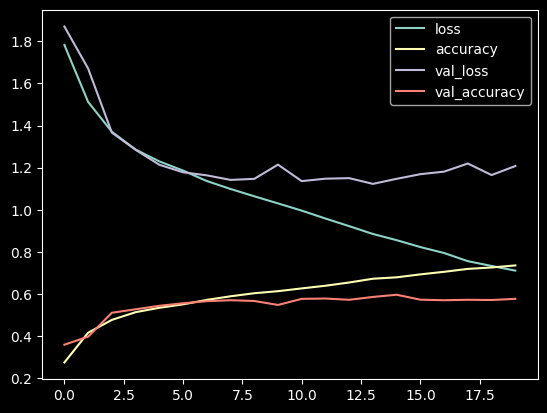

In [103]:
plt.figure(figsize=(15,8))
history_data.plot()
plt.show()

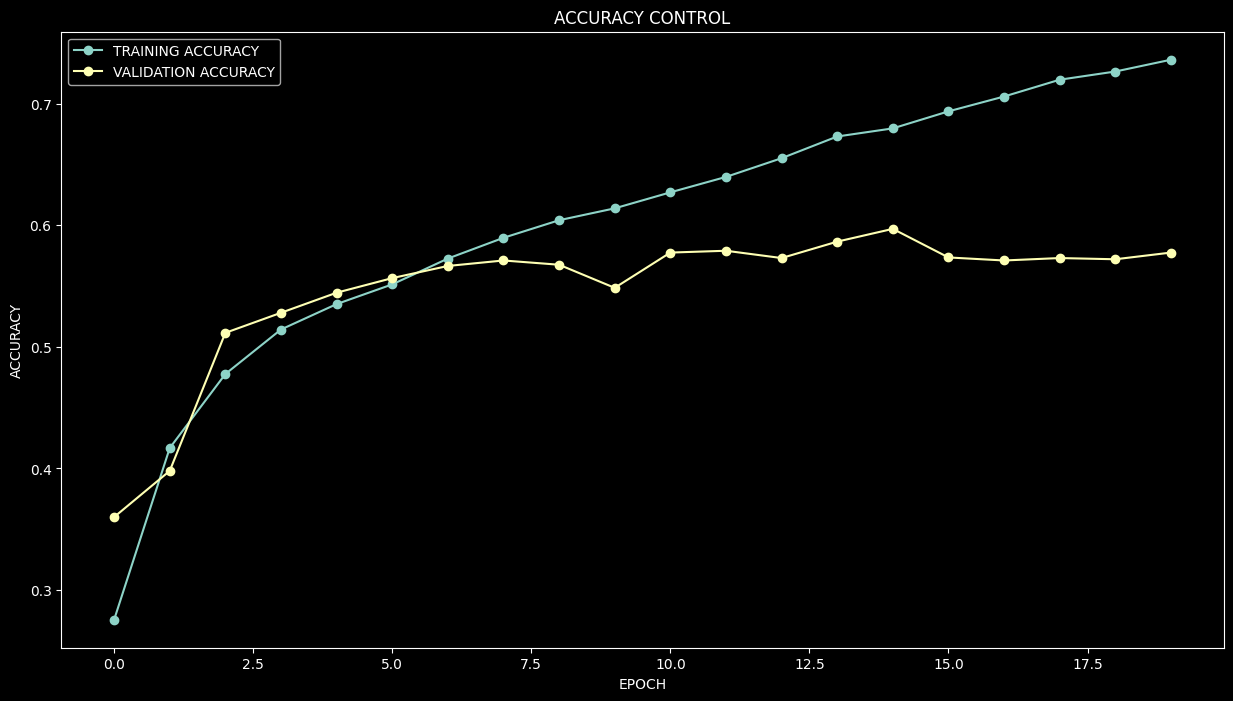

In [104]:
plt.figure(figsize=(15,8))
plt.plot(his.history["accuracy"],label="TRAINING ACCURACY",marker="o")
plt.plot(his.history["val_accuracy"],label="VALIDATION ACCURACY",marker="o")
plt.xlabel("EPOCH")
plt.ylabel("ACCURACY")
plt.title("ACCURACY CONTROL")
plt.legend()
plt.show()

In [105]:
model.save("testmodel.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
